咱们的基金是否存在着明显的周内效应呢？就是特定周几盈利高一些，让我们来验证一下吧。

In [1]:
import pandas as pd
from datetime import datetime
import trdb2py

isStaticImg = True
width = 960
height = 768

pd.options.display.max_columns = None
pd.options.display.max_rows = None

trdb2cfg = trdb2py.loadConfig('./trdb2.yaml')

我们先指定一个特定的基金，特定的时间段来分析吧。

In [2]:
# 具体基金
asset = 'jrj.510310'

# 起始时间，0表示从最开始算起
tsStart = 0
# tsStart = trdb2py.str2timestamp('2019-01-01', '%Y-%m-%d')

# 结束时间，-1表示到现在为止
tsEnd = -1
# tsEnd = trdb2py.str2timestamp('2020-01-01', '%Y-%m-%d')

# 初始资金池
paramsinit = trdb2py.trading2_pb2.InitParams(
    money=10000,
)

# 买入参数，用全部的钱来买入（也就是复利）
paramsbuy = trdb2py.trading2_pb2.BuyParams(
    perHandMoney=1,
)

# 卖出参数，全部卖出
paramssell = trdb2py.trading2_pb2.SellParams(
    perVolume=1,
)

lststart = [1, 2, 3, 4, 5]
lsttitle = ['周一', '周二', '周三', '周四', '周五']

首先看看这个基金的基准表现，就是在开始时间就直接买入，然后一直持有，看具体的收益率。

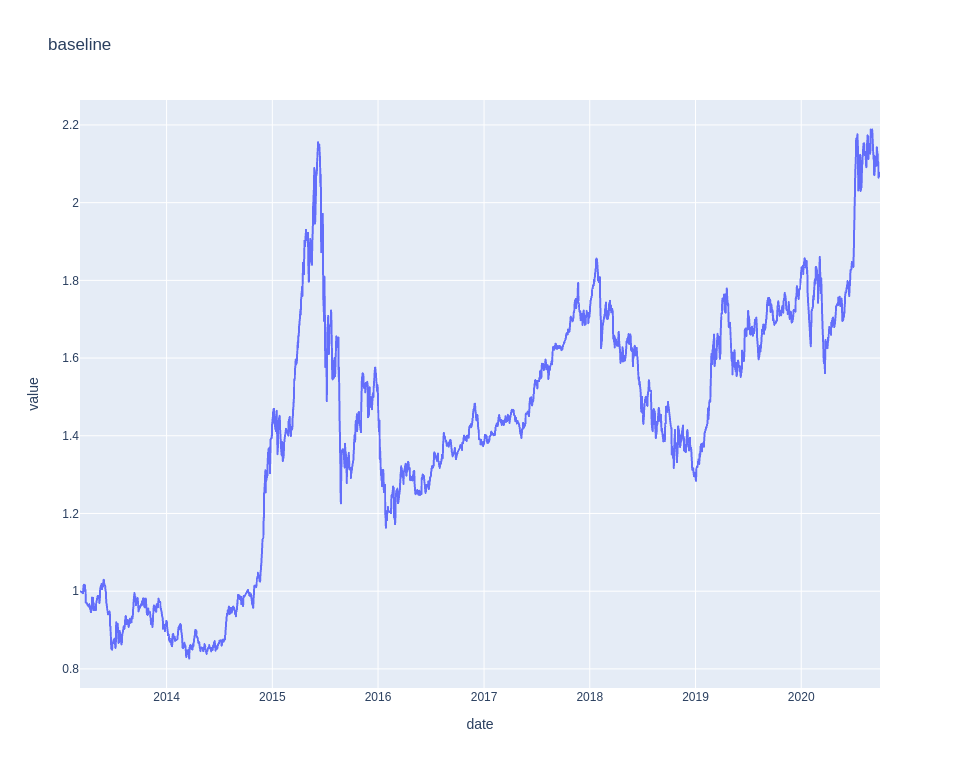

In [3]:
# baseline    
s0 = trdb2py.trading2_pb2.Strategy(
    name="normal",
    asset=trdb2py.str2asset(asset),         
)
        
buy0 = trdb2py.trading2_pb2.CtrlCondition(
    name='buyandhold',
)

paramsbuy = trdb2py.trading2_pb2.BuyParams(
    perHandMoney=1,
)

paramsinit = trdb2py.trading2_pb2.InitParams(
    money=10000,
)

s0.buy.extend([buy0])
s0.paramsBuy.CopyFrom(paramsbuy)
s0.paramsInit.CopyFrom(paramsinit)        
p0 = trdb2py.trading2_pb2.SimTradingParams(
    assets=[trdb2py.str2asset(asset)],
    startTs=tsStart,
    endTs=tsEnd,
    strategies=[s0],
    title='baseline',
)  

pnlBaseline = trdb2py.simTrading(trdb2cfg, p0)
trdb2py.showPNL(pnlBaseline, toImg=isStaticImg, width=width, height=height)

那么策略基准线大概就是这样了，7年多的时间2.2倍。

接下来，先看看最简单的情况，就是特定周几买入，第二天就卖出，只持有1天。

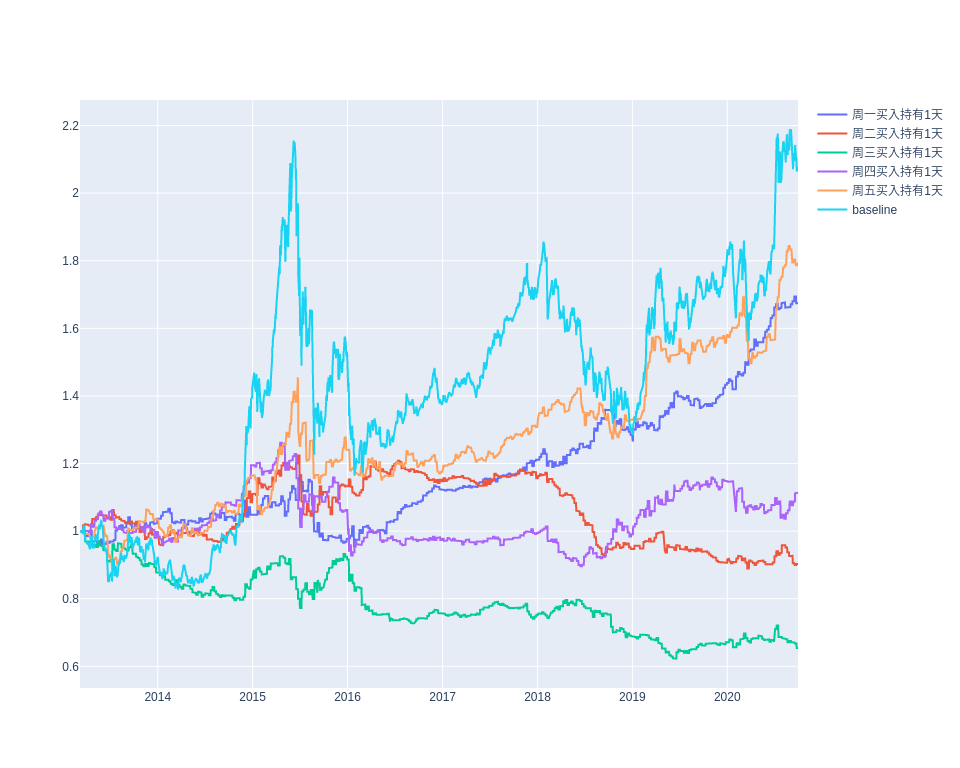

In [4]:
lstparams = []

for i in range(0, 5):
    buy0 = trdb2py.trading2_pb2.CtrlCondition(
        name='weekday',
        vals=[lststart[i]],
    )

    sell0 = trdb2py.trading2_pb2.CtrlCondition(
        name='weekday',
        vals=[trdb2py.nextWeekDay(lststart[i], 1)],
    )

    s0 = trdb2py.trading2_pb2.Strategy(
        name="normal",
        asset=trdb2py.str2asset(asset),
    )

    s0.buy.extend([buy0])
    s0.sell.extend([sell0])
    s0.paramsBuy.CopyFrom(paramsbuy)
    s0.paramsSell.CopyFrom(paramssell)
    s0.paramsInit.CopyFrom(paramsinit)        
    lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
        assets=[trdb2py.str2asset(asset)],
        startTs=tsStart,
        endTs=tsEnd,
        strategies=[s0],
        title='{}买入持有{}天'.format(lsttitle[i], 1),
    ))
 
lstpnl1 = trdb2py.simTradings(trdb2cfg, lstparams)

trdb2py.showPNLs(lstpnl1 + [pnlBaseline], toImg=isStaticImg, width=width, height=height)

如果看曲线图不是很清楚的话，我们列表看看

In [5]:
dfpnl1b = trdb2py.buildPNLReport(lstpnl1 + [pnlBaseline])

dfpnl1b[['title', 'maxDrawdown', 'maxDrawdownStart', 'maxDrawdownEnd', 'totalReturns', 'sharpe', 'annualizedReturns', 'annualizedVolatility', 'variance']].sort_values(by='totalReturns', ascending=False)

,title,maxDrawdown,maxDrawdownStart,maxDrawdownEnd,totalReturns,sharpe,annualizedReturns,annualizedVolatility,variance
5,baseline,0.460140,2015-06-08,2016-01-28,2.077782,0.486944,0.142459,0.230948,0.108601
4,周五买入持有1天,0.215150,2015-06-24,2015-09-18,1.791303,0.578518,0.104593,0.128937,0.042992
0,周一买入持有1天,0.180805,2015-06-30,2016-02-01,1.677655,0.638348,0.089571,0.093320,0.033625
3,周四买入持有1天,0.289543,2015-04-17,2018-06-21,1.113654,-0.131930,0.015023,0.113526,0.005748
1,周二买入持有1天,0.273412,2015-06-24,2020-03-24,0.902934,-0.490496,-0.012830,0.087320,0.009302
2,周三买入持有1天,0.377875,2013-03-21,2019-06-19,0.654525,-0.726173,-0.045664,0.104196,0.007876


我看可以看到，虽然盈利都不如基线，但由于波动率降低了。

特别是周一和周五，最大回撤都降低了50%以上，所以夏普都要高于基线。

上面的策略比较简单，因为有些节假日交易日，所以可能会出现买入了，但无法及时卖出的情况，下面我们换一个确定能卖出才买入的策略看看

In [6]:
def calcweekday2val2(wday, offday):
    if offday == 1:
        if wday == 5:
            return 3
    if offday == 2:
        if wday >= 4:
            return 4
    if offday == 3:
        if wday >= 3:
            return 5
    if offday == 4:
        if wday >= 2:
            return 6
        
    return offday


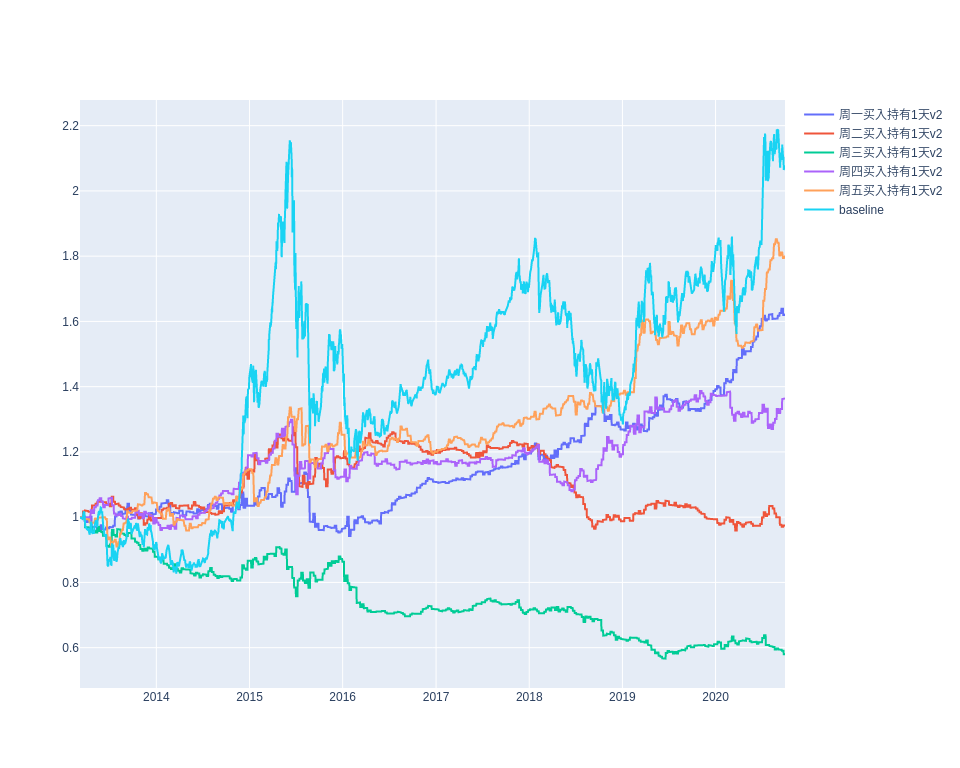

In [7]:
lstparams = []

for i in range(0, 5):
    buy0 = trdb2py.trading2_pb2.CtrlCondition(
        name='weekday2',
        vals=[lststart[i], calcweekday2val2(i + 1, 1)],
    )

    sell0 = trdb2py.trading2_pb2.CtrlCondition(
        name='weekday',
        vals=[trdb2py.nextWeekDay(lststart[i], 1)],
    )

    s0 = trdb2py.trading2_pb2.Strategy(
        name="normal",
        asset=trdb2py.str2asset(asset),
    )

    s0.buy.extend([buy0])
    s0.sell.extend([sell0])
    s0.paramsBuy.CopyFrom(paramsbuy)
    s0.paramsSell.CopyFrom(paramssell)
    s0.paramsInit.CopyFrom(paramsinit)        
    lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
        assets=[trdb2py.str2asset(asset)],
        startTs=tsStart,
        endTs=tsEnd,
        strategies=[s0],
        title='{}买入持有{}天v2'.format(lsttitle[i], 1),
    ))
 
lstpnl1t = trdb2py.simTradings(trdb2cfg, lstparams)

trdb2py.showPNLs(lstpnl1t + [pnlBaseline], toImg=isStaticImg, width=width, height=height)

In [8]:
dfpnl1b = trdb2py.buildPNLReport(lstpnl1 + lstpnl1t + [pnlBaseline])

dfpnl1b[['title', 'maxDrawdown', 'maxDrawdownStart', 'maxDrawdownEnd', 'totalReturns', 'sharpe', 'annualizedReturns', 'annualizedVolatility', 'variance']].sort_values(by='totalReturns', ascending=False)

,title,maxDrawdown,maxDrawdownStart,maxDrawdownEnd,totalReturns,sharpe,annualizedReturns,annualizedVolatility,variance
10,baseline,0.460140,2015-06-08,2016-01-28,2.077782,0.486944,0.142459,0.230948,0.108601
9,周五买入持有1天v2,0.136852,2015-06-08,2015-09-18,1.799036,0.638920,0.105615,0.118348,0.045984
4,周五买入持有1天,0.215150,2015-06-24,2015-09-18,1.791303,0.578518,0.104593,0.128937,0.042992
0,周一买入持有1天,0.180805,2015-06-30,2016-02-01,1.677655,0.638348,0.089571,0.093320,0.033625
5,周一买入持有1天v2,0.180805,2015-06-30,2016-02-01,1.623378,0.565634,0.082397,0.092634,0.029175
8,周四买入持有1天v2,0.176019,2015-06-12,2015-07-09,1.364055,0.182102,0.048120,0.099504,0.012243
3,周四买入持有1天,0.289543,2015-04-17,2018-06-21,1.113654,-0.131930,0.015023,0.113526,0.005748
6,周二买入持有1天v2,0.248132,2015-06-24,2020-03-24,0.974302,-0.399870,-0.003397,0.083519,0.008929
1,周二买入持有1天,0.273412,2015-06-24,2020-03-24,0.902934,-0.490496,-0.012830,0.087320,0.009302
2,周三买入持有1天,0.377875,2013-03-21,2019-06-19,0.654525,-0.726173,-0.045664,0.104196,0.007876


可以看到，虽然有一些差别，但其实影响有好有坏，下面我们还是按v2版的策略来吧

接下来看看胜率

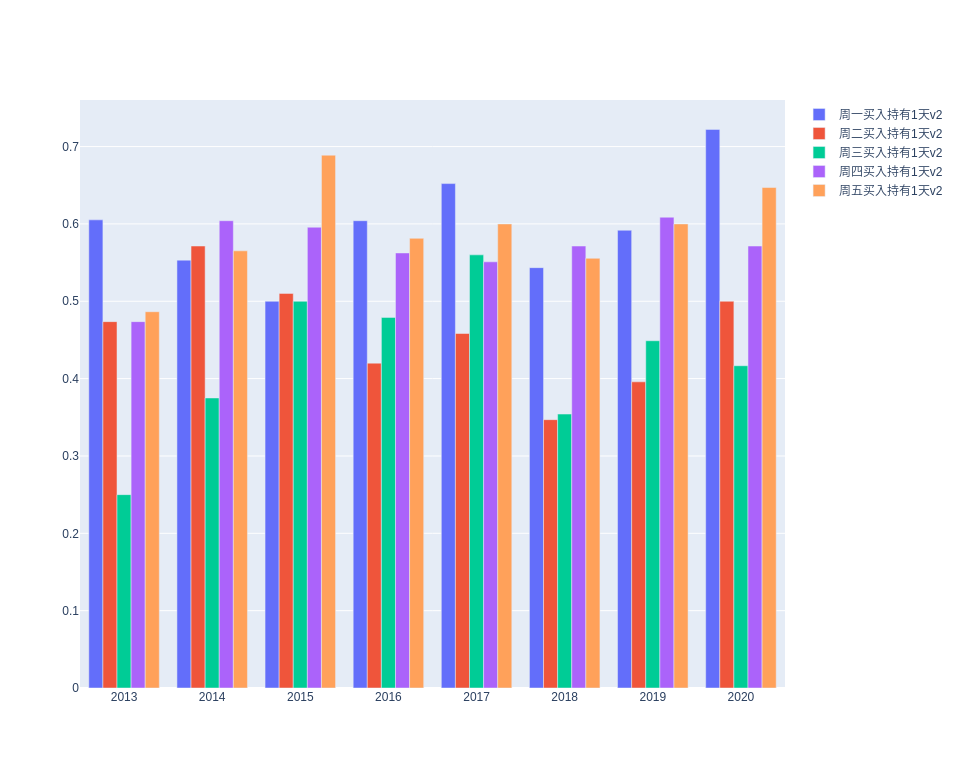

In [9]:
# trdb2py.showBarWinRate4Month(lstpnl1t, valtype='abs', valoff=-0.5, toImg=isStaticImg, width=width, height=height)
# trdb2py.showBarWinRate4Month(lstpnl1t, toImg=isStaticImg, width=width, height=height)
trdb2py.showBarWinRateInYears(lstpnl1t, toImg=isStaticImg, width=width, height=height)

对于这种随机策略，胜率应该均匀分布在0.5左右的，可以分别看看每一条数据，会发现，周五和周一还是要稍高于0.5的，周二周三稍低于0.5。

当然，这种策略交易比较频繁，次数足够，按月分布来看，没有明显的趋势，所以我们可以直接看整体汇总胜率。

In [10]:
wrmt = trdb2py.buildPNLWinRateInMonths(lstpnl1t)

wrmt[0][['title', 'total']]

,title,total
0,周一买入持有1天v2,0.592179
1,周二买入持有1天v2,0.457766
2,周三买入持有1天v2,0.429752
3,周四买入持有1天v2,0.569444
4,周五买入持有1天v2,0.591176


这里，我们对比一下纳指、标普、恒指、上证50、中证500、中小盘，可以得出以下结论：

1. 和走势曲线关系不大，同样大趋势向上的纳指和中小盘，胜率也是能看出差异来的。
2. 除了有明显高于0.5的以外，最好也能有明显低于0.5的，这样避开低于0.5的，持有高于0.5的，才能获得额外收益，最终明显超过基线。
3. 纳指、标普、恒指 都没有明显的周内效应。
4. A股普遍存在较明显的周内效应。
5. 越是小盘股，周内效应越明显。

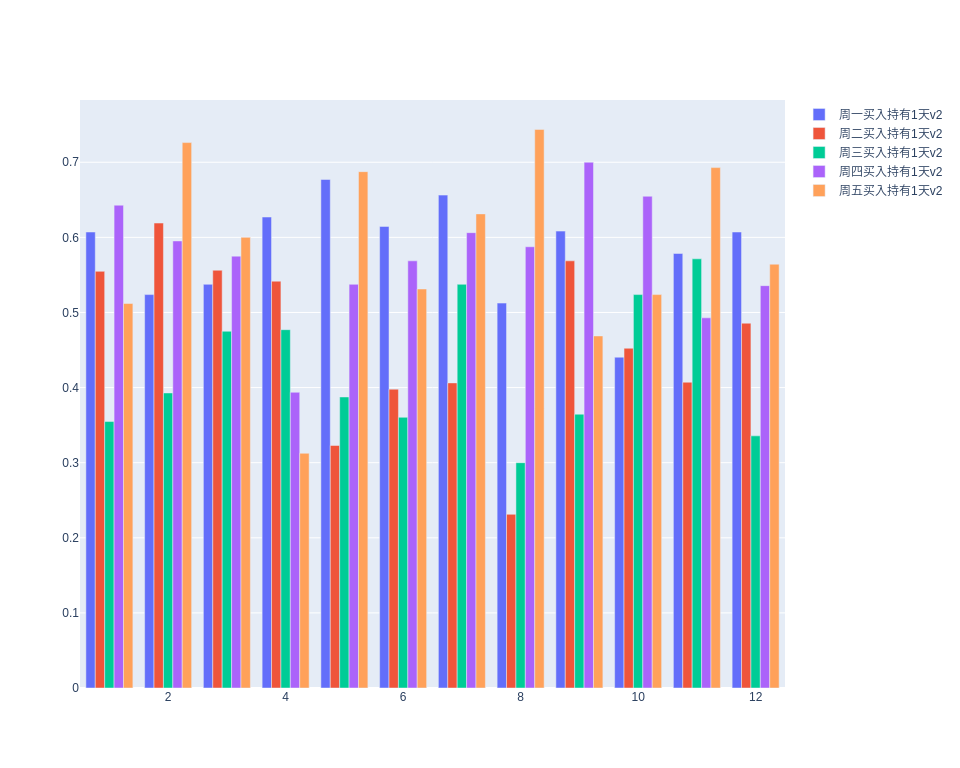

In [11]:
trdb2py.showBarWinRate4Month(lstpnl1t, toImg=isStaticImg, width=width, height=height)

接下来，我们统计一下不同月份的胜率，发现，胜率最突出的还是周五买入持有1天，但这个在4月和9月胜率偏低，特别是4月。

接下来看看4月的统计。

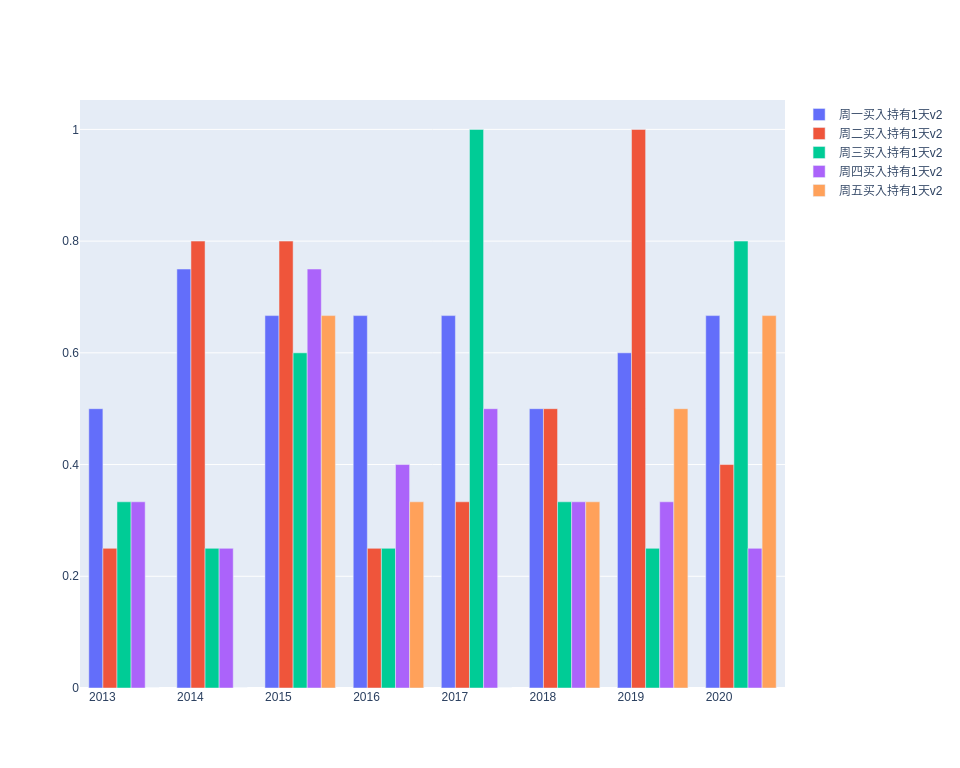

In [12]:
#trdb2py.showBarWinRateInMonths(lstpnl1t, valtype='abs', valoff=-0.5, month=8, toImg=isStaticImg, width=width, height=height)
trdb2py.showBarWinRateInMonths(lstpnl1t, month=4, toImg=isStaticImg, width=width, height=height)

发现除了2015年和2020年以外，4月确实都是输的。

但是，2015年和2020年4月其实都算是牛市了，不能这样简单的筛选。

目前看来，没有特别的证据表明有明显的可供配合的月度效应。

如果能把周五、周一的增长叠加起来，是不是结果会更好一些呢

干脆把持有1天到4天的情况，也就是从周一买周二卖，一直到 周一买周五卖，看看

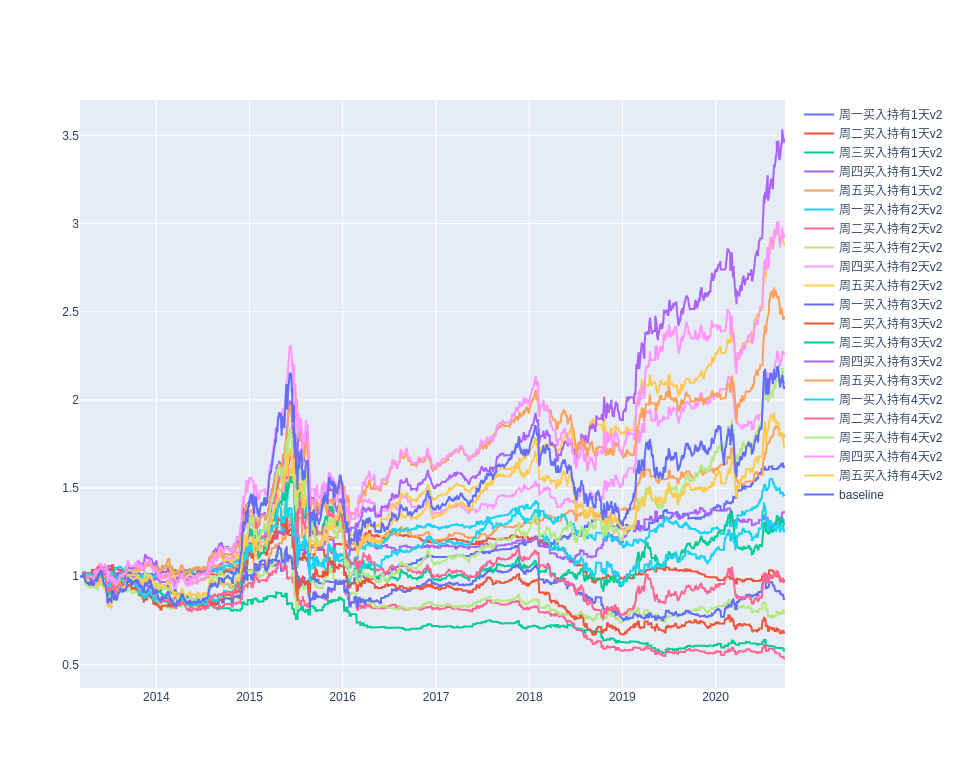

In [13]:
lstparams = []

for day in range(1, 5):
    for i in range(0, 5):
        buy0 = trdb2py.trading2_pb2.CtrlCondition(
            name='weekday2',
            vals=[lststart[i], calcweekday2val2(i + 1, day)],
        )

        sell0 = trdb2py.trading2_pb2.CtrlCondition(
            name='weekday',
            vals=[trdb2py.nextWeekDay(lststart[i], day)],
        )

        s0 = trdb2py.trading2_pb2.Strategy(
            name="normal",
            asset=trdb2py.str2asset(asset),
        )

        s0.buy.extend([buy0])
        s0.sell.extend([sell0])
        s0.paramsBuy.CopyFrom(paramsbuy)
        s0.paramsSell.CopyFrom(paramssell)
        s0.paramsInit.CopyFrom(paramsinit)        
        lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
            assets=[trdb2py.str2asset(asset)],
            startTs=tsStart,
            endTs=tsEnd,
            strategies=[s0],
            title='{}买入持有{}天v2'.format(lsttitle[i], day),
        ))
 
lstpnl = trdb2py.simTradings(trdb2cfg, lstparams)

trdb2py.showPNLs(lstpnl + [pnlBaseline], toImg=isStaticImg, width=width, height=height)

In [14]:
dfpnl = trdb2py.buildPNLReport(lstpnl + [pnlBaseline])

dfpnl[['title', 'maxDrawdown', 'maxDrawdownStart', 'maxDrawdownEnd', 'totalReturns', 'sharpe', 'annualizedReturns', 'annualizedVolatility', 'variance']].sort_values(by='totalReturns', ascending=False)

,title,maxDrawdown,maxDrawdownStart,maxDrawdownEnd,totalReturns,sharpe,annualizedReturns,annualizedVolatility,variance
13,周四买入持有3天v2,0.384071,2015-06-08,2016-01-28,3.481105,1.637045,0.327947,0.182003,0.357061
18,周四买入持有4天v2,0.433814,2015-06-08,2016-01-28,2.944286,1.138405,0.256991,0.199394,0.239115
9,周五买入持有2天v2,0.279939,2015-07-13,2016-02-01,2.897428,1.476733,0.250798,0.149518,0.223881
14,周五买入持有3天v2,0.351119,2015-06-30,2015-09-15,2.474167,0.967748,0.194852,0.170346,0.151066
8,周四买入持有2天v2,0.247141,2015-06-12,2016-01-15,2.267091,0.891478,0.167481,0.154217,0.106017
17,周三买入持有4天v2,0.481476,2015-06-08,2016-02-29,2.107109,0.561229,0.146335,0.207286,0.086599
20,baseline,0.460140,2015-06-08,2016-01-28,2.077782,0.486944,0.142459,0.230948,0.108601
4,周五买入持有1天v2,0.136852,2015-06-08,2015-09-18,1.799036,0.638920,0.105615,0.118348,0.045984
19,周五买入持有4天v2,0.351135,2015-06-08,2016-02-29,1.730605,0.344529,0.096570,0.193219,0.063496
0,周一买入持有1天v2,0.180805,2015-06-30,2016-02-01,1.623378,0.565634,0.082397,0.092634,0.029175


单看回报率，已经有明显超过基线的了，而且，最好的情况，夏普提升了近3倍

接下来，还能想到的，如果在下降的时候，定投买入，最终会不会也能获得额外收益呢？

还是周一到周五一起测一下吧。

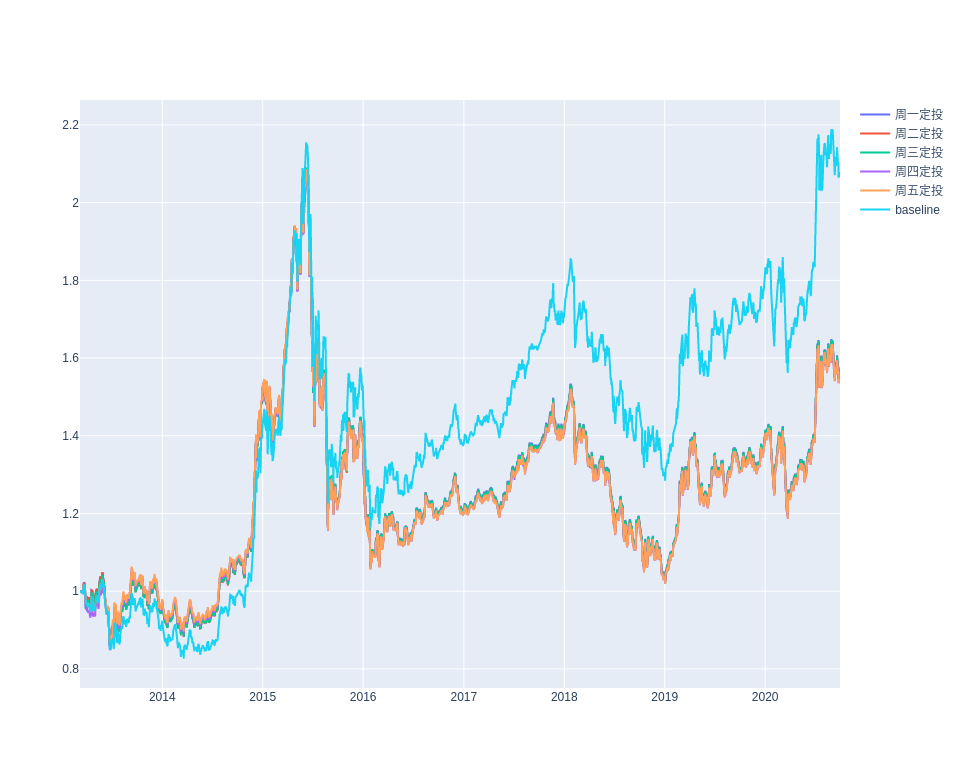

In [15]:
lstparams = []

for i in range(0, 5):
    buy0 = trdb2py.trading2_pb2.CtrlCondition(
        name='weekday',
        vals=[lststart[i]],
    )

    s0 = trdb2py.trading2_pb2.Strategy(
        name="normal",
        asset=trdb2py.str2asset(asset),
    )
    
    paramsaip = trdb2py.trading2_pb2.AIPParams(
        money=10000,
        type=trdb2py.trading2_pb2.AIPTT_MONTHDAY,
        day=lststart[i],
    )

    s0.buy.extend([buy0])
    s0.paramsBuy.CopyFrom(paramsbuy)
    s0.paramsSell.CopyFrom(paramssell)
    s0.paramsInit.CopyFrom(paramsinit)
    s0.paramsAIP.CopyFrom(paramsaip)
    lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
        assets=[trdb2py.str2asset(asset)],
        startTs=tsStart,
        endTs=tsEnd,
        strategies=[s0],
        title='{}定投'.format(lsttitle[i], day),
    ))
 
lstaippnl = trdb2py.simTradings(trdb2cfg, lstparams)

trdb2py.showPNLs(lstaippnl + [pnlBaseline], toImg=isStaticImg, width=width, height=height)

我们可以看到5条收益曲线几乎重合在一起，说明，特定周几购买，其实并没有差别。

关于定投，后面会有更详细的测试，这里还是回到如何榨取周内效应的最大收益上。

我们还可以考虑加入均线策略，看看在均线上下方买入，是否有区别，其实如果均线粒度够大，一定程度上能将牛市和熊市区分开。

这个运算量有点大，大概有24000种，我直接给出结论吧。

In [16]:
lstparams = []

for ema in range(5, 61):    
    for sdo in range(1, 5):
        for sd in range(1, 6):
            buy0 = trdb2py.trading2_pb2.CtrlCondition(
                name='weekday2',
                vals=[sd, calcweekday2val2(sd, sdo)],
            )

            buy1 = trdb2py.trading2_pb2.CtrlCondition(
                name='indicatorsp',
                operators=['up'],
                strVals=['ema.{}'.format(ema)],
            )
            
            sell0 = trdb2py.trading2_pb2.CtrlCondition(
                name='weekday',
                vals=[trdb2py.nextWeekDay(sd, sdo)],
            )

            sell1 = trdb2py.trading2_pb2.CtrlCondition(
                name='ctrlconditionid',
                vals=[1],
                strVals=['buy'],
            )            
            
            for edo in range(1, 5):
                for ed in range(1, 6):

                    buy2 = trdb2py.trading2_pb2.CtrlCondition(
                        name='weekday2',
                        vals=[ed, calcweekday2val2(ed, edo)],
                        group=1,
                    )

                    buy3 = trdb2py.trading2_pb2.CtrlCondition(
                        name='indicatorsp',
                        operators=['down'],
                        strVals=['ema.{}'.format(ema)],
                        group=1,    
                    )

                    sell2 = trdb2py.trading2_pb2.CtrlCondition(
                        name='weekday',
                        vals=[trdb2py.nextWeekDay(ed, edo)],
                        group=1,     
                    )

                    sell3 = trdb2py.trading2_pb2.CtrlCondition(
                        name='ctrlconditionid',
                        vals=[2],
                        strVals=['buy'],
                        group=1,     
                    )
            

                    s0 = trdb2py.trading2_pb2.Strategy(
                        name="normal",
                        asset=trdb2py.str2asset(asset),
                    )

                    s0.buy.extend([buy0, buy1, buy2, buy3])
                    s0.sell.extend([sell0, sell1, sell2, sell3])
                    s0.paramsBuy.CopyFrom(paramsbuy)
                    s0.paramsSell.CopyFrom(paramssell) 
                    s0.paramsInit.CopyFrom(paramsinit)        
                    lstparams.append(trdb2py.trading2_pb2.SimTradingParams(
                        assets=[trdb2py.str2asset(asset)],
                        startTs=tsStart,
                        endTs=tsEnd,
                        strategies=[s0],
                        title='ema{}up{}持有{}天down{}持有{}天'.format(ema, lsttitle[sd-1], sdo, lsttitle[ed-1], edo),
                    ))
 
lstpnlmix = trdb2py.simTradings(trdb2cfg, lstparams, ignoreTotalReturn=4)

# trdb2py.showPNLs(lstpnlmix + [pnlBaseline], toImg=isStaticImg, width=width, height=height)

In [17]:
dfpnl = trdb2py.buildPNLReport(lstpnlmix + [pnlBaseline])

dfpnl1 = dfpnl[dfpnl['totalReturns'] >= 1]

dfpnl1[['title', 'maxDrawdown', 'maxDrawdownStart', 'maxDrawdownEnd', 'totalReturns', 'sharpe', 'annualizedReturns', 'annualizedVolatility', 'variance']].sort_values(by='totalReturns', ascending=False)

,title,maxDrawdown,maxDrawdownStart,maxDrawdownEnd,totalReturns,sharpe,annualizedReturns,annualizedVolatility,variance
99,ema29up周四持有4天down周一持有4天,0.201493,2015-06-30,2016-01-28,6.019314,3.521241,0.663441,0.179892,1.614526
50,ema23up周四持有4天down周一持有4天,0.238650,2015-06-30,2016-01-28,5.813737,3.389241,0.636269,0.178880,1.511107
74,ema26up周四持有4天down周一持有4天,0.238650,2015-06-30,2016-01-28,5.742342,3.318494,0.626832,0.179850,1.516443
94,ema29up周四持有3天down周一持有4天,0.224412,2015-06-30,2016-01-28,5.632261,3.391561,0.612282,0.171685,1.195988
41,ema22up周四持有4天down周一持有4天,0.238650,2015-06-30,2016-01-28,5.587476,3.227604,0.606362,0.178573,1.439708
58,ema24up周四持有4天down周一持有4天,0.238650,2015-06-30,2016-01-28,5.541054,3.174999,0.600226,0.179599,1.319141
34,ema21up周四持有4天down周一持有4天,0.238650,2015-06-30,2016-01-28,5.478324,3.149376,0.591935,0.178427,1.381708
81,ema27up周四持有4天down周一持有4天,0.238650,2015-06-30,2016-01-28,5.432619,3.064834,0.585893,0.181378,1.261742
65,ema25up周四持有4天down周一持有4天,0.238650,2015-06-30,2016-01-28,5.407120,3.076392,0.582523,0.179601,1.250587
97,ema29up周四持有4天down周一持有1天,0.126344,2015-06-30,2015-11-03,5.382650,3.757539,0.579289,0.146183,1.362804


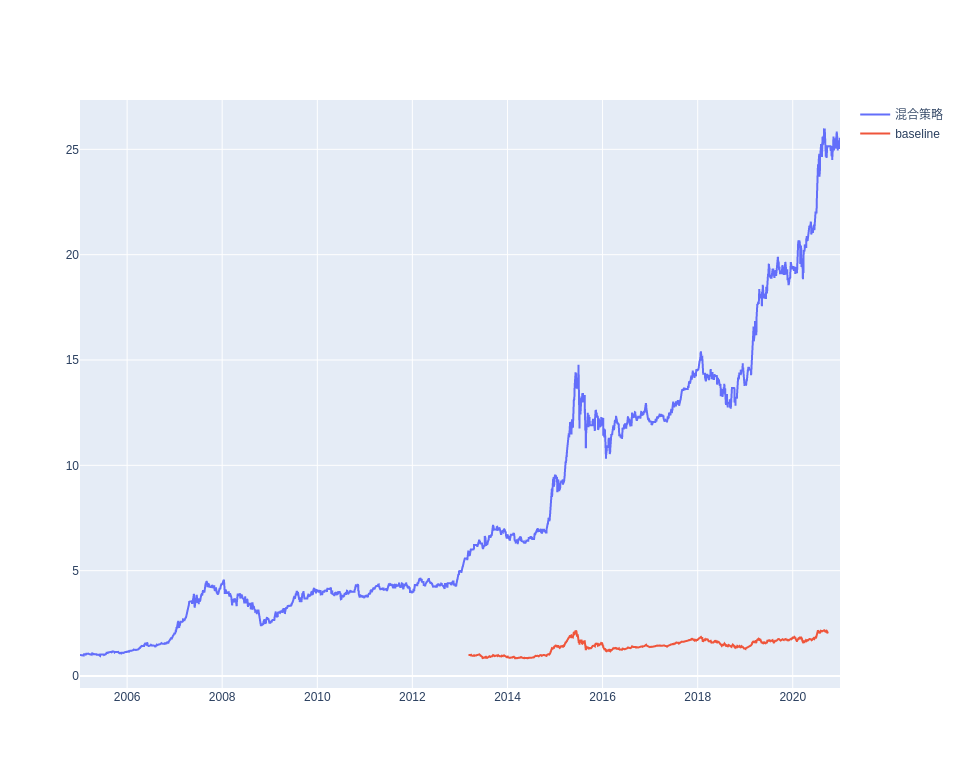

In [20]:
asset = 'jqdata.000300_XSHG|1d'
# asset = 'jqdata.000905_XSHG|1d'
# asset = 'jqdata.000932_XSHG|1d'

s0 = trdb2py.trading2_pb2.Strategy(
    name="normal",
    asset=trdb2py.str2asset(asset),         
)
        
buy0 = trdb2py.trading2_pb2.CtrlCondition(
    name='weekday2',
    vals=[4, calcweekday2val2(4, 4)],
)

buy1 = trdb2py.trading2_pb2.CtrlCondition(
    name='indicatorsp',
    operators=['up'],
    strVals=['ema.{}'.format(29)],
)

buy2 = trdb2py.trading2_pb2.CtrlCondition(
    name='weekday2',
    vals=[1, calcweekday2val2(1, 4)],
    group=1,
)

buy3 = trdb2py.trading2_pb2.CtrlCondition(
    name='indicatorsp',
    operators=['down'],
    strVals=['ema.29'],
    group=1,    
)

sell0 = trdb2py.trading2_pb2.CtrlCondition(
    name='weekday',
    vals=[3],
)

sell1 = trdb2py.trading2_pb2.CtrlCondition(
    name='ctrlconditionid',
    vals=[1],
    strVals=['buy'],
)

sell2 = trdb2py.trading2_pb2.CtrlCondition(
    name='weekday',
    vals=[5],
    group=1,     
)

sell3 = trdb2py.trading2_pb2.CtrlCondition(
    name='ctrlconditionid',
    vals=[2],
    strVals=['buy'],
    group=1,     
)

paramsbuy = trdb2py.trading2_pb2.BuyParams(
    perHandMoney=1,
)

paramsinit = trdb2py.trading2_pb2.InitParams(
    money=10000,
)

s0.buy.extend([buy0, buy1, buy2, buy3])
s0.sell.extend([sell0, sell1, sell2, sell3])
s0.paramsBuy.CopyFrom(paramsbuy)
s0.paramsSell.CopyFrom(paramssell) 
s0.paramsInit.CopyFrom(paramsinit)        
p0 = trdb2py.trading2_pb2.SimTradingParams(
    assets=[trdb2py.str2asset(asset)],
    startTs=tsStart,
    endTs=tsEnd,
    strategies=[s0],
    title='混合策略',
)  

pnlm = trdb2py.simTrading(trdb2cfg, p0)

trdb2py.showPNLs([pnlm, pnlBaseline], toImg=isStaticImg, width=width, height=height)